In [1]:
import pandas as pd

df = pd.read_json('sentiment_dataframe.json')
df.index = df.index.tz_localize('UTC')

df.head()


,sentiment_cumulative
2016-01-02 00:00:00+00:00,0.002324
2016-01-03 00:00:00+00:00,-0.006480
2016-01-04 00:00:00+00:00,-0.006080
2016-01-05 00:00:00+00:00,0.099588
2016-01-06 00:00:00+00:00,0.104035


<Axes: >

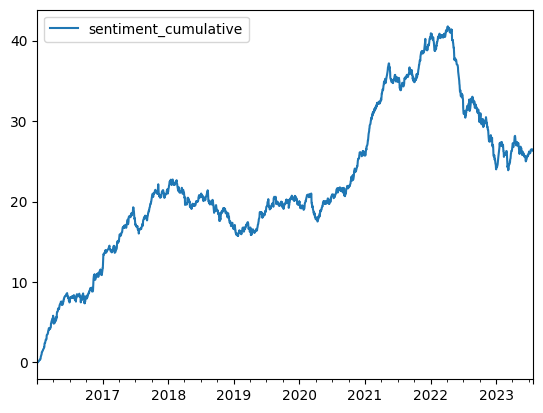

In [2]:
df.plot()

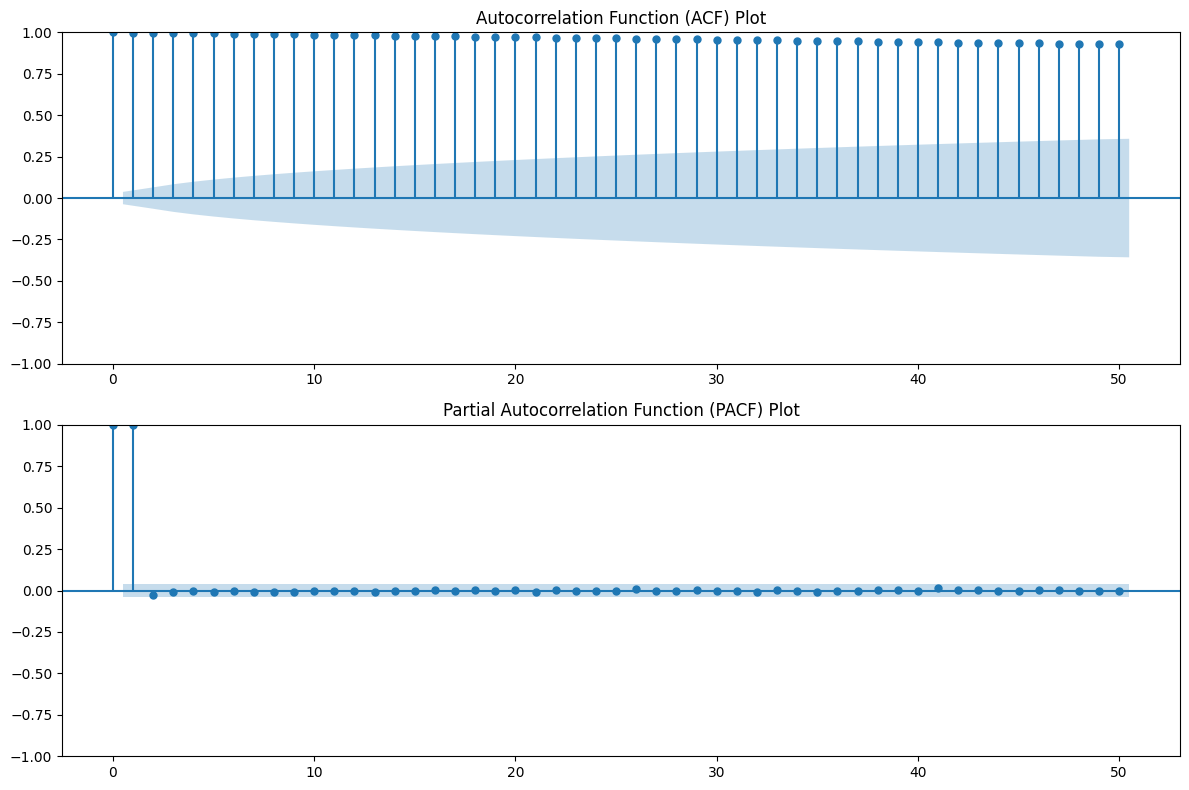

In [3]:
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 8))

# ACF plot
plot_acf(df['sentiment_cumulative'], lags=50, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF) Plot')

# PACF plot
plot_pacf(df['sentiment_cumulative'], lags=50, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF) Plot')

plt.tight_layout()
plt.show()

In [4]:
# Load the second dataset
df_eth = pd.read_csv('sentiment-indicator/data/assets/ETHUSDT.csv')

# Convert the 'Open time' column to datetime
df_eth['Open time'] = pd.to_datetime(df_eth['Open time'])
df_eth = df_eth.set_index('Open time')

df_eth.tail()

,Open,High,Low,Close,Volume,Quote volume,Trade count,Taker base volume,Taker quote volume
Open time,,,,,,,,,
2023-07-24 00:00:00+00:00,1888.74,1890.86,1833.19,1850.00,276504.5547,5.124029e+08,336366,132903.4964,2.461986e+08
2023-07-25 00:00:00+00:00,1850.00,1868.71,1845.45,1857.66,152251.2100,2.826966e+08,248856,74772.6946,1.388422e+08
2023-07-26 00:00:00+00:00,1857.66,1888.00,1848.35,1872.00,272090.5333,5.070493e+08,319851,148093.9082,2.759393e+08
2023-07-27 00:00:00+00:00,1871.99,1886.11,1854.84,1861.28,163766.4259,3.064636e+08,252294,80701.9300,1.510482e+08
2023-07-28 00:00:00+00:00,1861.29,1883.39,1856.52,1874.19,138695.7147,2.592285e+08,219389,70493.2035,1.317680e+08


In [5]:
df_eth = df_eth.drop(columns=['Open', 'High', 'Low', 'Volume'])
df_eth = df_eth.drop(columns=['Quote volume', 'Trade count', 'Taker base volume', 'Taker quote volume'])
df_eth.tail()

,Close
Open time,
2023-07-24 00:00:00+00:00,1850.00
2023-07-25 00:00:00+00:00,1857.66
2023-07-26 00:00:00+00:00,1872.00
2023-07-27 00:00:00+00:00,1861.28
2023-07-28 00:00:00+00:00,1874.19


In [6]:
# Create a new date range
full_date_range = pd.date_range(start=df_eth.index.min(), end=df_eth.index.max())

# Find the missing dates by comparing the new date range with the dataframe's index
missing_dates = full_date_range.difference(df_eth.index)

print(missing_dates)

DatetimeIndex([], dtype='datetime64[ns, UTC]', freq='D')


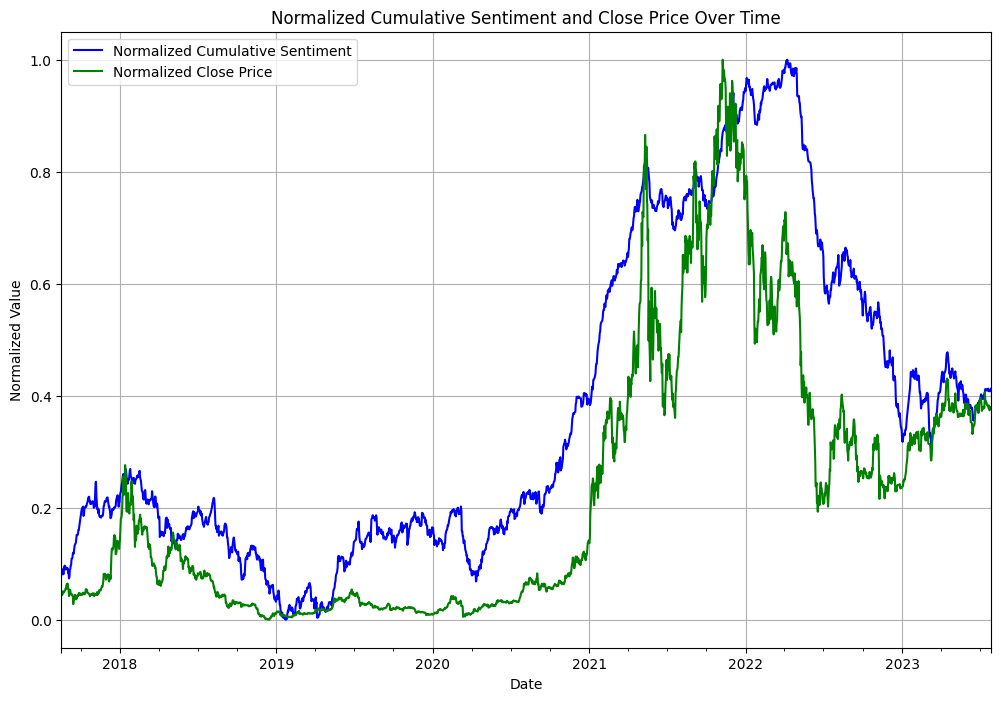

In [7]:
# Merge the two datasets on 'date'
df_merged = pd.merge(df_eth, df, left_index=True, right_index=True, how='inner')

# Save DataFrame as a JSON file
df_merged.to_json('sentiment_dataframe_merged.json')

# Normalizing the 'sentiment_cumulative' and 'Close' columns for better visualization
df_merged['sentiment_cumulative_normalized'] = (df_merged['sentiment_cumulative'] - df_merged['sentiment_cumulative'].min()) / (df_merged['sentiment_cumulative'].max() - df_merged['sentiment_cumulative'].min())
df_merged['Close_normalized'] = (df_merged['Close'] - df_merged['Close'].min()) / (df_merged['Close'].max() - df_merged['Close'].min())

# Plotting the normalized cumulative sentiment and Close price
plt.figure(figsize=(12, 8))
df_merged['sentiment_cumulative_normalized'].plot(color='blue', label='Normalized Cumulative Sentiment')
df_merged['Close_normalized'].plot(color='green', label='Normalized Close Price')
plt.title('Normalized Cumulative Sentiment and Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Calculate the correlation
correlation = df_merged[['sentiment_cumulative', 'Close']].corr()

correlation

,sentiment_cumulative,Close
sentiment_cumulative,1.000000,0.917405
Close,0.917405,1.000000


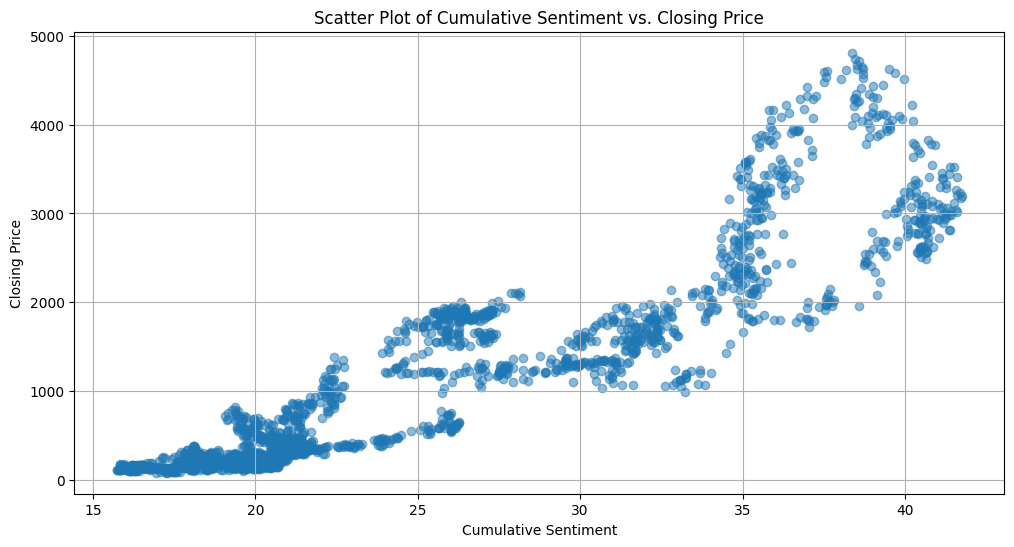

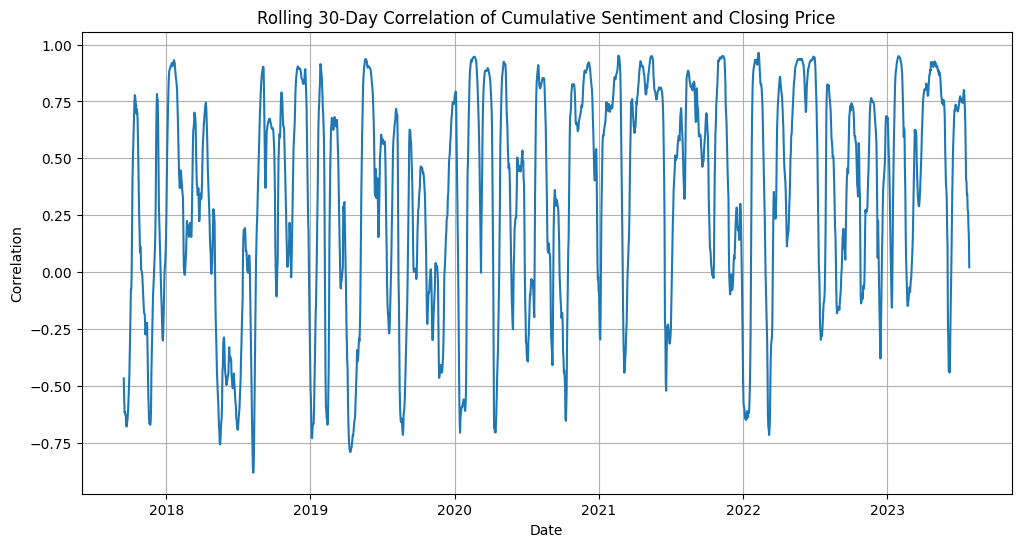

In [9]:
# Scatter plot of sentiment vs. closing price
plt.figure(figsize=(12, 6))
plt.scatter(df_merged['sentiment_cumulative'], df_merged['Close'], alpha=0.5)
plt.title('Scatter Plot of Cumulative Sentiment vs. Closing Price')
plt.xlabel('Cumulative Sentiment')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

# Rolling correlation plot
rolling_corr = df_merged['sentiment_cumulative'].rolling(window=30).corr(df_merged['Close'])
plt.figure(figsize=(12, 6))
plt.plot(df_merged.index, rolling_corr)
plt.title('Rolling 30-Day Correlation of Cumulative Sentiment and Closing Price')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

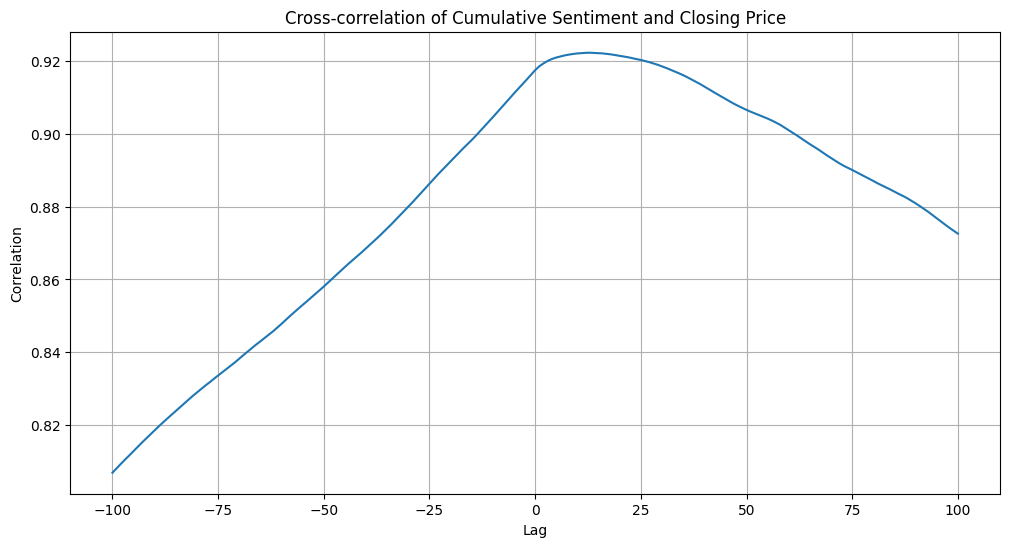

In [10]:
from scipy.signal import correlate

# Calculate the cross-correlation
lags = range(-100, 101)
cross_corr = [df_merged['sentiment_cumulative'].corr(df_merged['Close'].shift(lag)) for lag in lags]

# Plot the cross-correlation
plt.figure(figsize=(12, 6))
plt.plot(lags, cross_corr)
plt.title('Cross-correlation of Cumulative Sentiment and Closing Price')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()

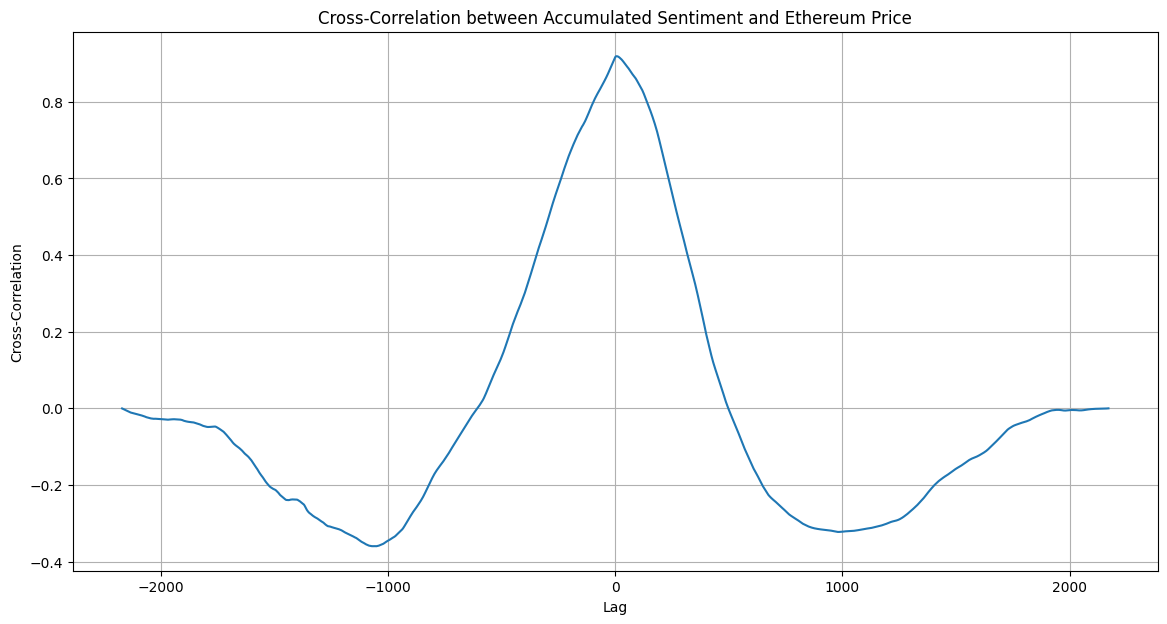

In [11]:
import numpy as np

# Normalize the accumulated sentiment and price data
sentiment_norm = (df_merged['sentiment_cumulative'] - df_merged['sentiment_cumulative'].mean()) / df_merged['sentiment_cumulative'].std()
price_norm = (df_merged['Close'] - df_merged['Close'].mean()) / df_merged['Close'].std()

# Compute the cross-correlation
lags = np.arange(-len(sentiment_norm) + 1, len(sentiment_norm))
ccov = np.correlate(sentiment_norm - sentiment_norm.mean(), price_norm - price_norm.mean(), mode='full')
ccor = ccov / (len(sentiment_norm) * sentiment_norm.std() * price_norm.std())

# Plot the cross-correlation
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(lags, ccor)
ax.set_xlabel('Lag')
ax.set_ylabel('Cross-Correlation')
ax.set_title('Cross-Correlation between Accumulated Sentiment and Ethereum Price')
ax.grid(True)
plt.show()

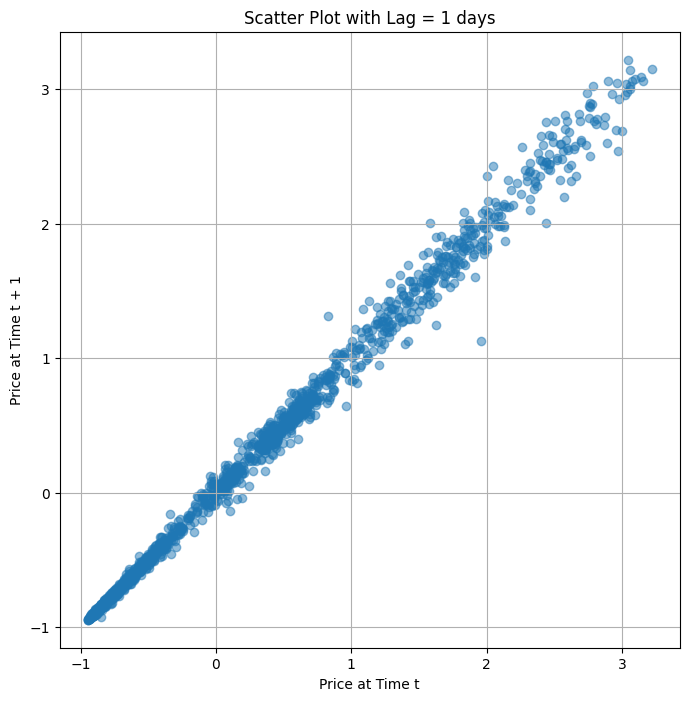

In [12]:
# Function to create a lagged scatter plot
def lagged_scatter_eth(price, lag):
    plt.figure(figsize=(8, 8))
    plt.scatter(price[:-lag], price[lag:], alpha=0.5)
    plt.title(f'Scatter Plot with Lag = {lag} days')
    plt.xlabel('Price at Time t')
    plt.ylabel(f'Price at Time t + {lag}')
    plt.grid(True)
    plt.show()

lagged_scatter_eth(price_norm, 1)

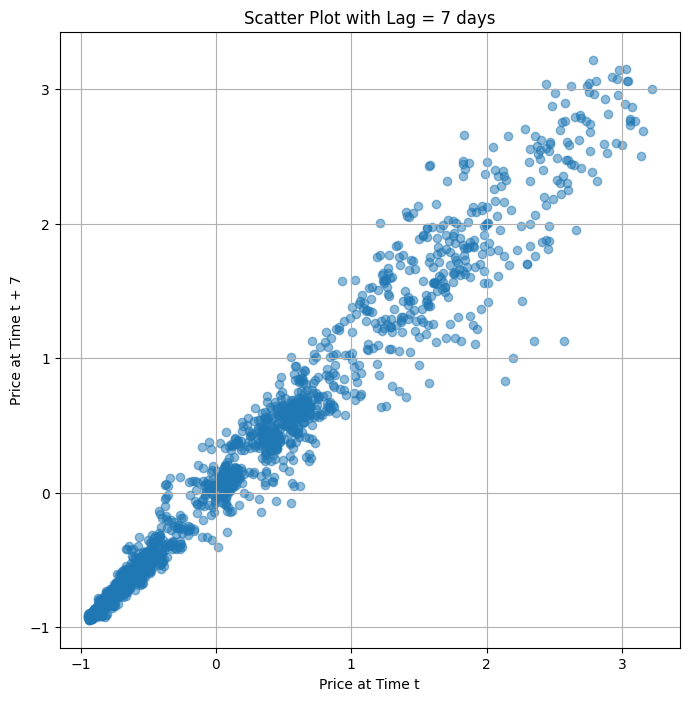

In [13]:
lagged_scatter_eth(price_norm, 7)

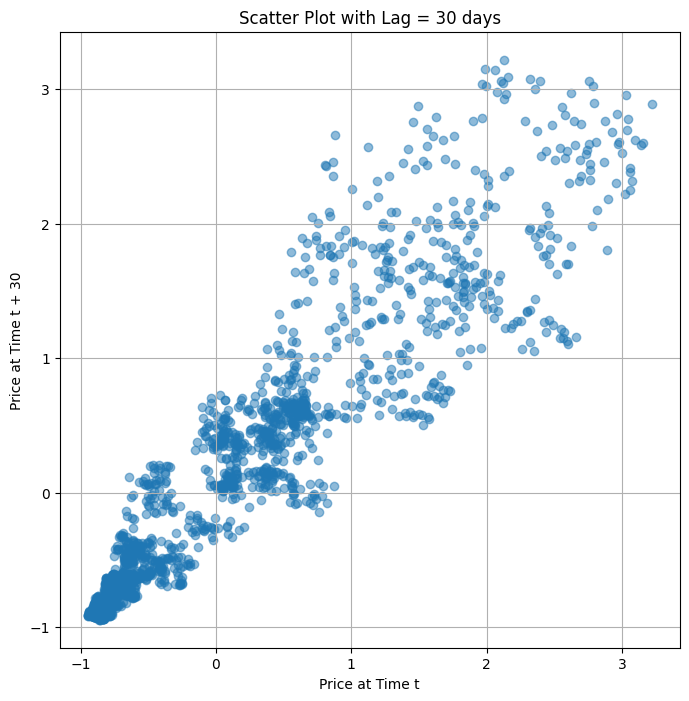

In [14]:
lagged_scatter_eth(price_norm, 30)

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests

# Perform the Granger causality test with a maximum lag of 10
maxlag = 10
test = 'ssr_chi2test'
result_granger = grangercausalitytests(df_merged[['Close', 'sentiment_cumulative']], maxlag)

# Extract the p-values
p_values = [round(result_granger[i+1][0][test][1], 4) for i in range(maxlag)]


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6277  , p=0.2022  , df_denom=2168, df_num=1
ssr based chi2 test:   chi2=1.6299  , p=0.2017  , df=1
likelihood ratio test: chi2=1.6293  , p=0.2018  , df=1
parameter F test:         F=1.6277  , p=0.2022  , df_denom=2168, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7616  , p=0.1720  , df_denom=2165, df_num=2
ssr based chi2 test:   chi2=3.5314  , p=0.1711  , df=2
likelihood ratio test: chi2=3.5285  , p=0.1713  , df=2
parameter F test:         F=1.7616  , p=0.1720  , df_denom=2165, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5029  , p=0.2119  , df_denom=2162, df_num=3
ssr based chi2 test:   chi2=4.5232  , p=0.2102  , df=3
likelihood ratio test: chi2=4.5184  , p=0.2107  , df=3
parameter F test:         F=1.5029  , p=0.2119  , df_denom=2162, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4024  , p=0.

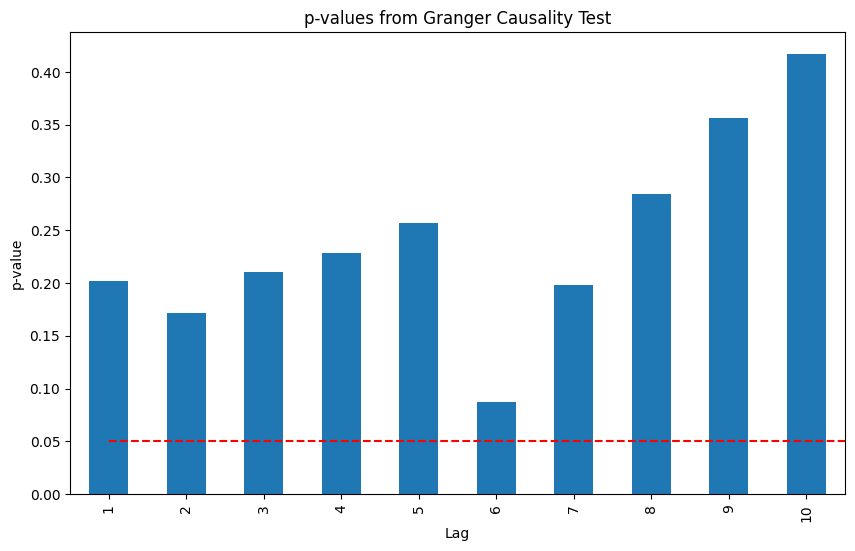

In [16]:
# Convert the p-values into a pandas Series for easy plotting
p_values_series = pd.Series(p_values, index=range(1, maxlag+1))

# Create a bar plot of the p-values
plt.figure(figsize=(10, 6))
p_values_series.plot(kind='bar')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title('p-values from Granger Causality Test')
plt.hlines(0.05, xmin=0, xmax=maxlag+1, colors='r', linestyles='dashed')
plt.show()